1.Logistic Regression

This notebook demonstrates Logistic Regression applied on the MNIST dataset (digits 0 and 1 only).

Import Required Libraries

In [4]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



Load and Visualize MNIST Data

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),  # convert image to PyTorch tensor
    transforms.Normalize((0.0,), (1.0,))  # normalize to [0,1]
])

mnist_train = datasets.MNIST(root='data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='data', train=False, transform=transform, download=True)


In [6]:
print(f"Number of training samples: {len(mnist_train)}")

Number of training samples: 60000


Sample Images

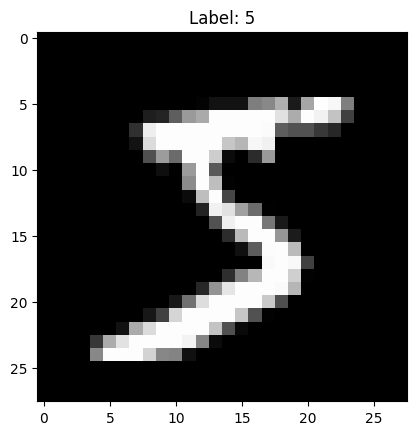

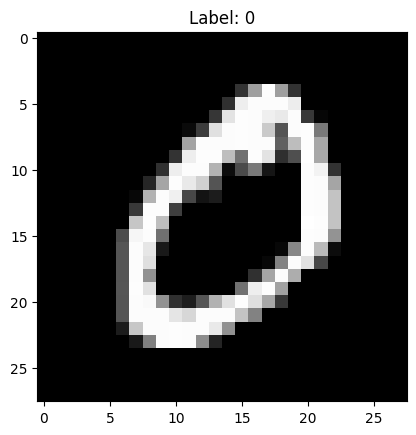

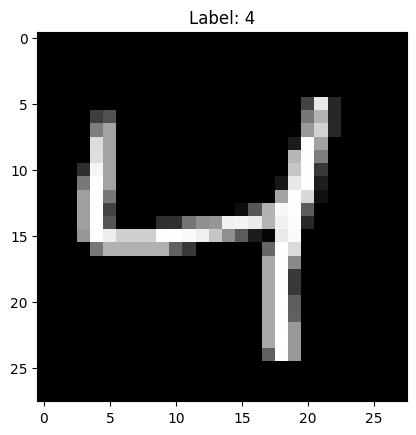

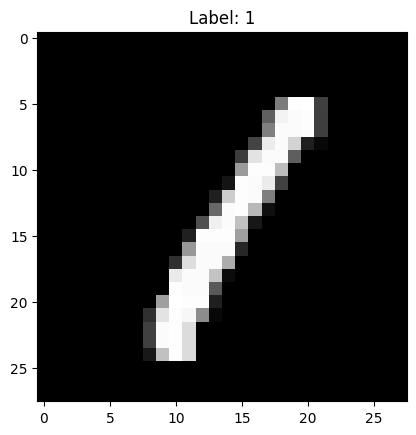

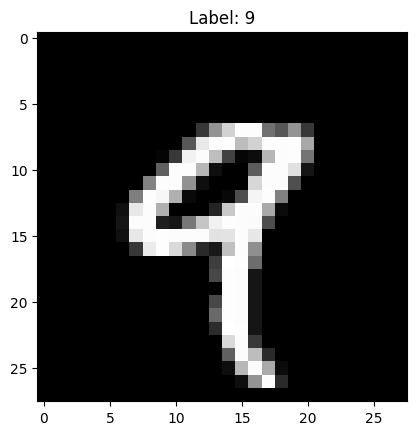

In [7]:

for i in range(5):
    image, label = mnist_train[i]
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Label: {label}")
    plt.show()


Data Preprocessing

In [8]:
X = []
y = []

for img, label in mnist_train:
    if label in [0, 1]:
        X.append(img.view(-1))  # flatten 28x28 -> 784
        y.append(label)

X = torch.stack(X)
y = torch.tensor(y)


Split into Train, Validation, Test

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)
print(f"Train size: {X_train.shape[0]}, Val size: {X_val.shape[0]}, Test size: {X_test.shape[0]}")

Train size: 7599, Val size: 2533, Test size: 2533


Create DataLoaders

In [10]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64)

Manual Logistic Regression Implementation (from scratch)

Helper Functions

In [11]:
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))


In [12]:
def binary_cross_entropy(y_hat, y):
    eps = 1e-15
    y_hat = torch.clamp(y_hat, eps, 1 - eps) # prevent log(0)
    #y_hat < eps = eps
    #y_hat > 1 - eps = 1 - eps
    return -torch.mean(y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat))


Initialize Parameters

In [13]:
# Number of features = 784 pixels per image
n_features = 784

# Initialize weights and bias
W = torch.zeros((n_features, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

Training Loop

In [14]:
# --- Hyperparameters and trackers ---
learning_rate = 0.01
epochs = 100
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

# --- Training loop ---
for epoch in range(epochs):
    epoch_loss = 0.0
    correct_train = 0
    total_train = 0

    # ----- TRAINING PHASE -----
    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred = sigmoid(X_batch @ W + b)
        loss = binary_cross_entropy(y_pred, y_batch.unsqueeze(1).float())

        # Backward pass
        loss.backward()

        # Gradient update (manual SGD)
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        # Reset gradients
        W.grad.zero_()
        b.grad.zero_()

        # Accumulate batch loss
        epoch_loss += loss.item()
        # Compute training accuracy per batch
        preds = (y_pred > 0.5).int().squeeze()
        correct_train += (preds == y_batch).sum().item()
        total_train += y_batch.size(0)        

    # Compute average training loss for this epoch
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(correct_train / total_train)

    # ----- VALIDATION PHASE -----
    with torch.no_grad():
        val_loss_total = 0.0
        correct = 0
        total = 0

        for X_val_batch, y_val_batch in val_loader:
            y_val_pred = sigmoid(X_val_batch @ W + b)
            val_loss_total += binary_cross_entropy(y_val_pred, y_val_batch.unsqueeze(1).float()).item()

            # Compute accuracy
            y_val_pred_label = (y_val_pred > 0.5).int().squeeze()
            correct += (y_val_pred_label == y_val_batch).sum().item()
            total += y_val_batch.size(0)

        avg_val_loss = val_loss_total / len(val_loader)
        val_acc = correct / total

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

    # Print progress for this epoch
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Train Acc: {train_accuracies[-1]:.4f} | "
          f"Val Acc: {val_accuracies[-1]:.4f}")

Epoch 1/100 | Train Loss: 0.2307 | Val Loss: 0.1076 | Train Acc: 0.9904 | Val Acc: 0.9968
Epoch 2/100 | Train Loss: 0.0784 | Val Loss: 0.0639 | Train Acc: 0.9964 | Val Acc: 0.9968
Epoch 3/100 | Train Loss: 0.0523 | Val Loss: 0.0475 | Train Acc: 0.9967 | Val Acc: 0.9968
Epoch 4/100 | Train Loss: 0.0406 | Val Loss: 0.0387 | Train Acc: 0.9971 | Val Acc: 0.9968
Epoch 5/100 | Train Loss: 0.0339 | Val Loss: 0.0332 | Train Acc: 0.9972 | Val Acc: 0.9968
Epoch 6/100 | Train Loss: 0.0294 | Val Loss: 0.0293 | Train Acc: 0.9978 | Val Acc: 0.9968
Epoch 7/100 | Train Loss: 0.0262 | Val Loss: 0.0265 | Train Acc: 0.9976 | Val Acc: 0.9968
Epoch 8/100 | Train Loss: 0.0237 | Val Loss: 0.0243 | Train Acc: 0.9978 | Val Acc: 0.9972
Epoch 9/100 | Train Loss: 0.0218 | Val Loss: 0.0226 | Train Acc: 0.9979 | Val Acc: 0.9972
Epoch 10/100 | Train Loss: 0.0202 | Val Loss: 0.0212 | Train Acc: 0.9979 | Val Acc: 0.9972
Epoch 11/100 | Train Loss: 0.0190 | Val Loss: 0.0200 | Train Acc: 0.9979 | Val Acc: 0.9972
Epoch 12

Loss and Accuracy Curves

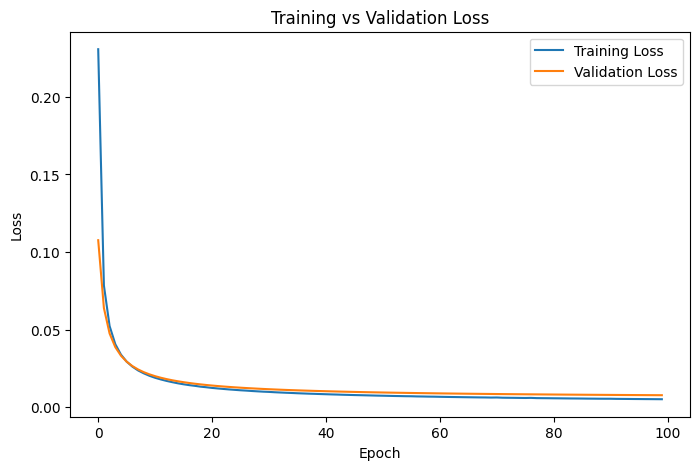

In [15]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


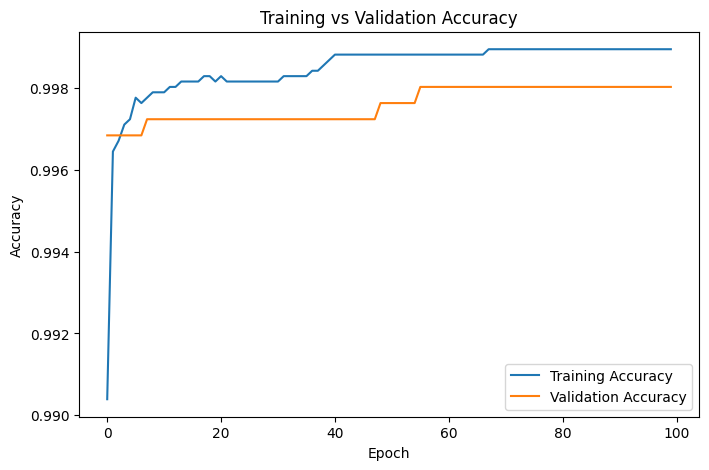

In [16]:
plt.figure(figsize=(8,5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

Evaluate on Test Set

Test Accuracy: 0.9972


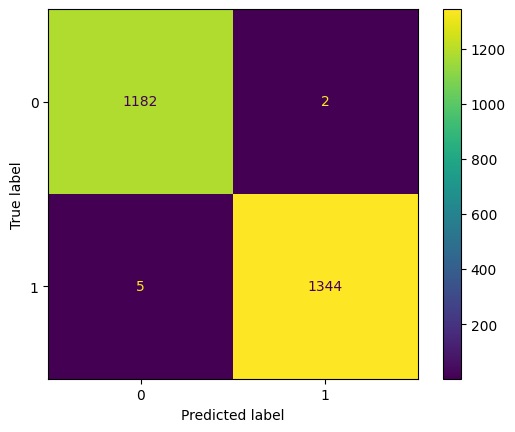

In [17]:
with torch.no_grad():
    y_test_pred = sigmoid(X_test @ W + b)
    y_test_pred_label = (y_test_pred > 0.5).int().squeeze()

test_acc = (y_test_pred_label == y_test).float().mean()
print(f"Test Accuracy: {test_acc:.4f}")

cm = confusion_matrix(y_test, y_test_pred_label)
ConfusionMatrixDisplay(cm).plot()
plt.show()


Comparison with Sklearn Logistic Regression

In [18]:
model_sklearn = LogisticRegression(max_iter=100, solver='liblinear')
model_sklearn.fit(X_train, y_train)

train_acc_sklearn = model_sklearn.score(X_train, y_train)
val_acc_sklearn = model_sklearn.score(X_val, y_val)
test_acc_sklearn = model_sklearn.score(X_test, y_test)

print(f"Sklearn Logistic Regression - Training Accuracy: {train_acc_sklearn:.4f}")
print(f"Sklearn Logistic Regression - Validation Accuracy: {val_acc_sklearn:.4f}")
print(f"Sklearn Logistic Regression - Test Accuracy: {test_acc_sklearn:.4f}")


Sklearn Logistic Regression - Training Accuracy: 1.0000
Sklearn Logistic Regression - Validation Accuracy: 0.9980
Sklearn Logistic Regression - Test Accuracy: 0.9976


In [19]:
manual_final_train_acc = train_accuracies[-1]
manual_final_val_acc = val_accuracies[-1]



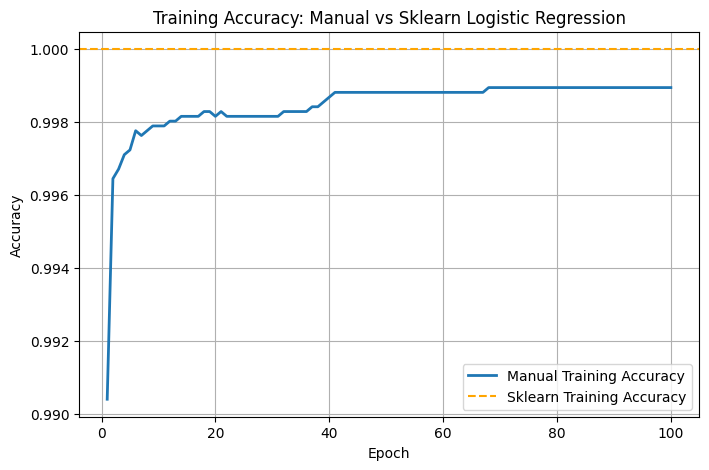

In [20]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Manual Training Accuracy', linewidth=2)
plt.axhline(y=train_acc_sklearn, color='orange', linestyle='--', label='Sklearn Training Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy: Manual vs Sklearn Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

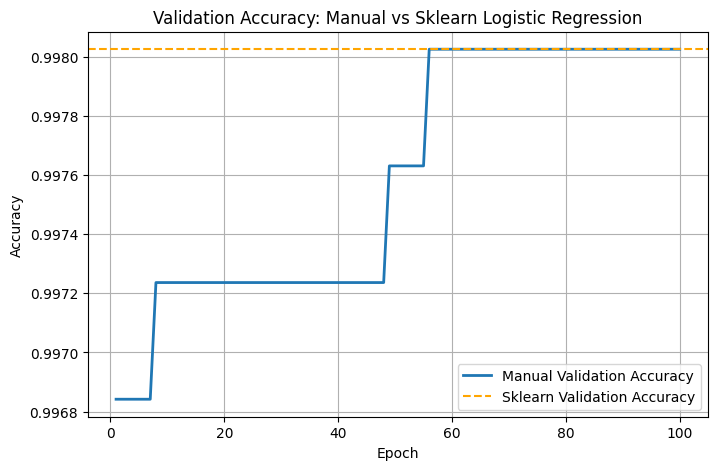

In [21]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Manual Validation Accuracy', linewidth=2)
plt.axhline(y=val_acc_sklearn, color='orange', linestyle='--', label='Sklearn Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy: Manual vs Sklearn Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

Manual vs Sklearn Accuracy Comparison

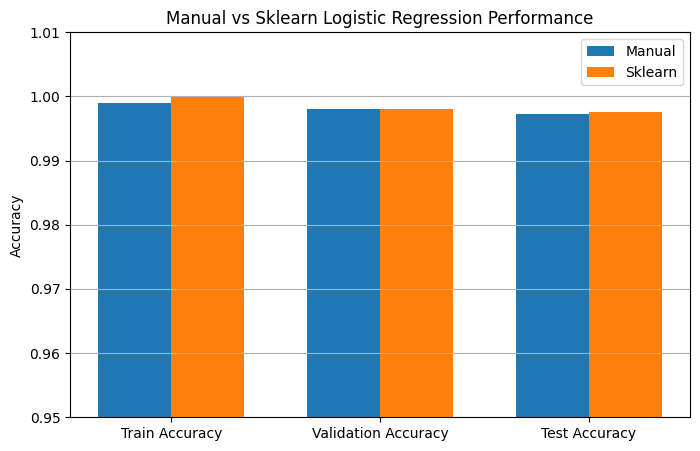

In [22]:
labels = ['Train Accuracy', 'Validation Accuracy', 'Test Accuracy']
manual_values = [
    manual_final_train_acc,
    manual_final_val_acc,
    (y_test_pred_label == y_test).float().mean().item()
]
sklearn_values = [
    train_acc_sklearn,
    val_acc_sklearn,
    model_sklearn.score(X_test, y_test)
]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, manual_values, width, label='Manual')
plt.bar(x + width/2, sklearn_values, width, label='Sklearn')
plt.ylabel('Accuracy')
plt.title('Manual vs Sklearn Logistic Regression Performance')
plt.xticks(x, labels)
plt.ylim(0.95, 1.01)
plt.legend()
plt.grid(axis='y')
plt.show()

Logistic Regression Using PyTorch Layers

In [23]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='data', train=True, transform=transform, download=True)

In [24]:
# Filter digits 0 and 1
X = []
y = []
for img, label in mnist_train:
    if label in [0, 1]:
        X.append(img.view(-1))
        y.append(label)

X = torch.stack(X)
y = torch.tensor(y, dtype=torch.float32) 

In [25]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)
print(f"Train set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Train set size: 7599
Validation set size: 2533
Test set size: 2533


In [26]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=64)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=64)

In [27]:
model = nn.Linear(784, 1)


In [28]:
criterion = nn.BCEWithLogitsLoss()       # combines sigmoid + BCE for stability
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [29]:
epochs = 100
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # TRAIN
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).int()
        correct_train += (preds == y_batch.int()).sum().item()
        total_train += y_batch.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            outputs_val = model(X_val_batch).squeeze()
            loss = criterion(outputs_val, y_val_batch)
            val_loss += loss.item()

            preds_val = (torch.sigmoid(outputs_val) > 0.5).int()
            correct_val += (preds_val == y_val_batch.int()).sum().item()
            total_val += y_val_batch.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/100 | Train Loss: 0.2443 | Val Loss: 0.1138 | Train Acc: 0.9697 | Val Acc: 0.9941
Epoch 2/100 | Train Loss: 0.0798 | Val Loss: 0.0686 | Train Acc: 0.9966 | Val Acc: 0.9949
Epoch 3/100 | Train Loss: 0.0528 | Val Loss: 0.0519 | Train Acc: 0.9967 | Val Acc: 0.9949
Epoch 4/100 | Train Loss: 0.0409 | Val Loss: 0.0430 | Train Acc: 0.9968 | Val Acc: 0.9949
Epoch 5/100 | Train Loss: 0.0341 | Val Loss: 0.0374 | Train Acc: 0.9971 | Val Acc: 0.9949
Epoch 6/100 | Train Loss: 0.0296 | Val Loss: 0.0335 | Train Acc: 0.9971 | Val Acc: 0.9953
Epoch 7/100 | Train Loss: 0.0264 | Val Loss: 0.0306 | Train Acc: 0.9971 | Val Acc: 0.9957
Epoch 8/100 | Train Loss: 0.0240 | Val Loss: 0.0284 | Train Acc: 0.9971 | Val Acc: 0.9961
Epoch 9/100 | Train Loss: 0.0221 | Val Loss: 0.0266 | Train Acc: 0.9972 | Val Acc: 0.9961
Epoch 10/100 | Train Loss: 0.0205 | Val Loss: 0.0251 | Train Acc: 0.9972 | Val Acc: 0.9961
Epoch 11/100 | Train Loss: 0.0193 | Val Loss: 0.0239 | Train Acc: 0.9972 | Val Acc: 0.9961
Epoch 12

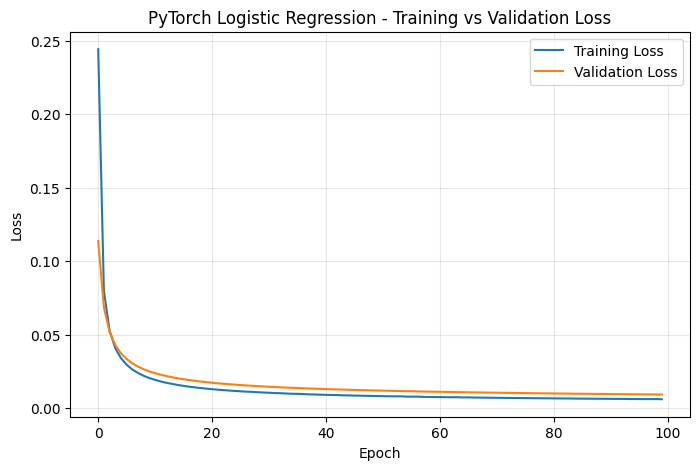

In [30]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PyTorch Logistic Regression - Training vs Validation Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

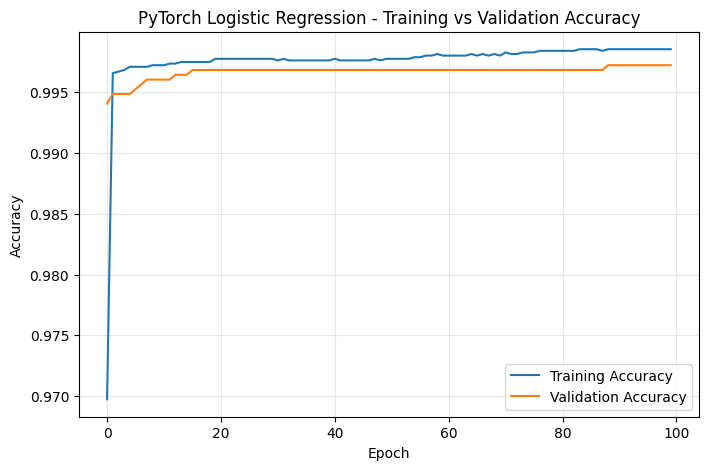

In [31]:
plt.figure(figsize=(8,5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('PyTorch Logistic Regression - Training vs Validation Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Final Test Accuracy (PyTorch Built-in): 0.9996


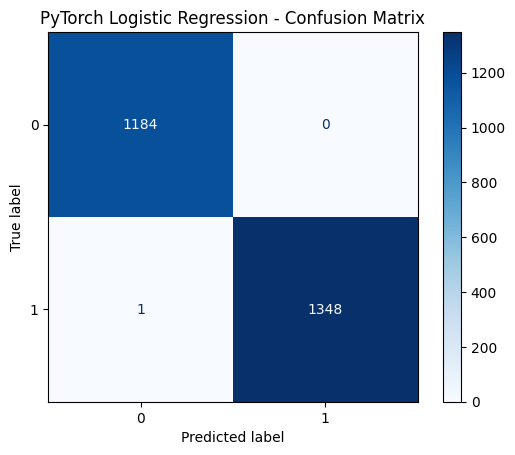

In [32]:
model.eval()
with torch.no_grad():
    outputs_test = model(X_test).squeeze()
    preds_test = (torch.sigmoid(outputs_test) > 0.5).int()
    test_acc = (preds_test == y_test.int()).float().mean().item()

print(f"\nFinal Test Accuracy (PyTorch Built-in): {test_acc:.4f}")

cm = confusion_matrix(y_test.int(), preds_test)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("PyTorch Logistic Regression - Confusion Matrix")
plt.show()